In [2]:
!pip install imbalanced-learn xgboost textblob vaderSentiment tqdm seaborn

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.feature_selection import SelectKBest, f_classif
from imblearn.over_sampling import SMOTE
from textblob import TextBlob
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re
from tqdm.notebook import tqdm
import gc

# Download NLTK resources
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')



[notice] A new release of pip is available: 24.2 -> 25.0
[notice] To update, run: python.exe -m pip install --upgrade pip
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Ritesh\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Ritesh\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Ritesh\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Ritesh\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [3]:
df = pd.read_csv("mbti_1.csv")


In [4]:
df.head()

,type,posts
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...
1,ENTP,'I'm finding the lack of me in these posts ver...
2,INTP,'Good one _____ https://www.youtube.com/wat...
3,INTJ,"'Dear INTP, I enjoyed our conversation the o..."
4,ENTJ,'You're fired.|||That's another silly misconce...


In [5]:
# Convert text to lowercase and remove unwanted characters
df['clean_text'] = df['posts'].astype(str).str.lower()
df['clean_text'] = df['clean_text'].apply(lambda x: re.sub(r'http\S+|www.\S+', '', x))
df['clean_text'] = df['clean_text'].apply(lambda x: re.sub(r'[^a-z ]', '', x))

# Tokenization and Lemmatization
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

df['clean_text'] = df['clean_text'].apply(lambda x: ' '.join(
    [lemmatizer.lemmatize(word) for word in word_tokenize(x) if word not in stop_words]
))


In [6]:
analyzer = SentimentIntensityAnalyzer()

feature_list = []
for text in tqdm(df['clean_text']):
    sentiment = analyzer.polarity_scores(text)
    blob = TextBlob(text)
    tokens = word_tokenize(text)

    features = {
        'pos': sentiment['pos'],
        'neu': sentiment['neu'],
        'neg': sentiment['neg'],
        'compound': sentiment['compound'],
        'polarity': blob.sentiment.polarity,
        'subjectivity': blob.sentiment.subjectivity,
        'num_words': len(tokens),
        'num_unique_words': len(set(tokens)),
        'avg_word_length': np.mean([len(w) for w in tokens]) if tokens else 0,
        'num_sentences': max(text.count('.') + text.count('!') + text.count('?'), 1),
    }
    features['avg_sentence_length'] = features['num_words'] / features['num_sentences']
    
    feature_list.append(features)

features_df = pd.DataFrame(feature_list)


  0%|          | 0/8675 [00:00<?, ?it/s]

In [7]:
vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1,2))
X_tfidf = vectorizer.fit_transform(df['clean_text']).toarray()


In [8]:
df.head()

,type,posts,clean_text
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...,intj moment sportscenter top ten play prankswh...
1,ENTP,'I'm finding the lack of me in these posts ver...,im finding lack post alarmingsex boring positi...
2,INTP,'Good one _____ https://www.youtube.com/wat...,good one course say know thats blessing cursed...
3,INTJ,"'Dear INTP, I enjoyed our conversation the o...",dear intp enjoyed conversation day esoteric ga...
4,ENTJ,'You're fired.|||That's another silly misconce...,youre firedthats another silly misconception a...


In [9]:
feature_list

[{'pos': 0.261,
  'neu': 0.685,
  'neg': 0.054,
  'compound': 0.9967,
  'polarity': 0.10477052268718935,
  'subjectivity': 0.4691251803751802,
  'num_words': 300,
  'num_unique_words': 258,
  'avg_word_length': 5.883333333333334,
  'num_sentences': 1,
  'avg_sentence_length': 300.0},
 {'pos': 0.266,
  'neu': 0.627,
  'neg': 0.108,
  'compound': 0.9987,
  'polarity': 0.0859553744128212,
  'subjectivity': 0.5063036520217372,
  'num_words': 584,
  'num_unique_words': 404,
  'avg_word_length': 5.484589041095891,
  'num_sentences': 1,
  'avg_sentence_length': 584.0},
 {'pos': 0.283,
  'neu': 0.615,
  'neg': 0.102,
  'compound': 0.9984,
  'polarity': 0.15674886295139465,
  'subjectivity': 0.5802682338758286,
  'num_words': 433,
  'num_unique_words': 336,
  'avg_word_length': 5.939953810623557,
  'num_sentences': 1,
  'avg_sentence_length': 433.0},
 {'pos': 0.186,
  'neu': 0.726,
  'neg': 0.088,
  'compound': 0.9958,
  'polarity': 0.0993763528138528,
  'subjectivity': 0.5251140873015872,
  'n

In [10]:
scaler = MinMaxScaler()
X_numerical = scaler.fit_transform(features_df)


In [11]:
X = np.hstack((X_tfidf, X_numerical))


In [12]:
print(X)

[[0.         0.         0.         ... 0.74626352 0.         0.31578947]
 [0.         0.02673942 0.         ... 0.69568534 0.         0.61473684]
 [0.08947132 0.03226366 0.         ... 0.75344547 0.         0.45578947]
 ...
 [0.         0.         0.         ... 0.76341575 0.         0.51052632]
 [0.         0.04002579 0.         ... 0.71796271 0.         0.87052632]
 [0.         0.02423657 0.         ... 0.70504267 0.         0.66736842]]


In [13]:
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(df['type'])


In [14]:
print(y)
print(label_encoder)

[ 8  3 11 ... 11  9  9]
LabelEncoder()


In [15]:
selector = SelectKBest(score_func=f_classif, k=5000)
X = selector.fit_transform(X, y)


c:\Users\Ritesh\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:111: UserWarning: Features [5009] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
c:\Users\Ritesh\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:112: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


In [16]:
smote = SMOTE(random_state=42)
X, y = smote.fit_resample(X, y)


In [17]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


In [18]:
!pip install --upgrade scikit-learn xgboost


   ---------------------------------------- 0.0/11.1 MB ? eta -:--:--
   --- ------------------------------------ 1.0/11.1 MB 6.3 MB/s eta 0:00:02
   ---- ----------------------------------- 1.3/11.1 MB 3.5 MB/s eta 0:00:03
   ------- -------------------------------- 2.1/11.1 MB 4.1 MB/s eta 0:00:03
   ----------- ---------------------------- 3.1/11.1 MB 3.8 MB/s eta 0:00:03
   -------------- ------------------------- 3.9/11.1 MB 3.9 MB/s eta 0:00:02
   ---------------- ----------------------- 4.7/11.1 MB 3.9 MB/s eta 0:00:02
   ------------------- -------------------- 5.5/11.1 MB 3.9 MB/s eta 0:00:02
   ---------------------- ----------------- 6.3/11.1 MB 3.9 MB/s eta 0:00:02
   ------------------------- -------------- 7.1/11.1 MB 3.9 MB/s eta 0:00:02
   ---------------------------- ----------- 7.9/11.1 MB 3.9 MB/s eta 0:00:01
   ------------------------------ --------- 8.4/11.1 MB 3.9 MB/s eta 0:00:01
   --------------------------------- ------ 9.4/11.1 MB 3.9 MB/s eta 0:00:01
   ---

  You can safely remove it manually.

[notice] A new release of pip is available: 24.2 -> 25.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [19]:
# Train Random Forest
rf_model = RandomForestClassifier(n_estimators=200, random_state=42)
rf_model.fit(X_train, y_train)

# Evaluate Random Forest
y_pred_rf = rf_model.predict(X_test)
rf_accuracy = accuracy_score(y_test, y_pred_rf)
print(f"Random Forest Accuracy: {rf_accuracy:.4f}")


Random Forest Accuracy: 0.9410


In [22]:
pip install xgboost


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.2 -> 25.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [24]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

# Train XGBoost with GPU
xgb_model = XGBClassifier(
    n_estimators=200,
    random_state=42,
    tree_method='hist',  # Use the 'hist' method for GPU support
    device='cuda',       # Use GPU (CUDA)
    n_jobs=1  # Optional: set to 1 to avoid multi-threading issues
)

# Fit the model to your data
xgb_model.fit(X_train, y_train)

# Evaluate XGBoost
y_pred_xgb = xgb_model.predict(X_test)
xgb_accuracy = accuracy_score(y_test, y_pred_xgb)
print(f"XGBoost Accuracy (GPU): {xgb_accuracy:.4f}")


c:\Users\Ritesh\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [20:09:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)


XGBoost Accuracy (GPU): 0.9347


In [26]:
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.metrics import accuracy_score

# Train Gradient Boosting using HistGradientBoosting (GPU support)
gb_model = HistGradientBoostingClassifier(max_iter=200, random_state=42)
gb_model.fit(X_train, y_train)

# Evaluate Gradient Boosting
y_pred_gb = gb_model.predict(X_test)
gb_accuracy = accuracy_score(y_test, y_pred_gb)
print(f"Gradient Boosting Accuracy: {gb_accuracy:.4f}")


Gradient Boosting Accuracy: 0.9352


In [27]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score

# Train MLP (Multi-layer Perceptron) model
mlp_model = MLPClassifier(hidden_layer_sizes=(128, 64), max_iter=500, random_state=42)
mlp_model.fit(X_train, y_train)

# Evaluate MLP
y_pred_mlp = mlp_model.predict(X_test)
mlp_accuracy = accuracy_score(y_test, y_pred_mlp)
print(f"MLP Accuracy: {mlp_accuracy:.4f}")


MLP Accuracy: 0.9301


In [28]:
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score

# Train CatBoost model
catboost_model = CatBoostClassifier(iterations=200, random_state=42, silent=True)
catboost_model.fit(X_train, y_train)

# Evaluate CatBoost
y_pred_catboost = catboost_model.predict(X_test)
catboost_accuracy = accuracy_score(y_test, y_pred_catboost)
print(f"CatBoost Accuracy: {catboost_accuracy:.4f}")


CatBoost Accuracy: 0.8659


In [29]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Train Logistic Regression model
logreg_model = LogisticRegression(max_iter=500, random_state=42)
logreg_model.fit(X_train, y_train)

# Evaluate Logistic Regression
y_pred_logreg = logreg_model.predict(X_test)
logreg_accuracy = accuracy_score(y_test, y_pred_logreg)
print(f"Logistic Regression Accuracy: {logreg_accuracy:.4f}")


Logistic Regression Accuracy: 0.9072


In [30]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

# Train SVM model
svm_model = SVC(kernel='linear', random_state=42)  # You can change the kernel to 'rbf', 'poly', etc.
svm_model.fit(X_train, y_train)

# Evaluate SVM
y_pred_svm = svm_model.predict(X_test)
svm_accuracy = accuracy_score(y_test, y_pred_svm)
print(f"SVM Accuracy: {svm_accuracy:.4f}")


SVM Accuracy: 0.9331


Train Classification Report:
              precision  recall  f1-score  support
0                   1.0     1.0       1.0   1456.0
1                   1.0     1.0       1.0   1472.0
2                   1.0     1.0       1.0   1431.0
3                   1.0     1.0       1.0   1488.0
4                   1.0     1.0       1.0   1450.0
5                   1.0     1.0       1.0   1461.0
6                   1.0     1.0       1.0   1481.0
7                   1.0     1.0       1.0   1441.0
8                   1.0     1.0       1.0   1472.0
9                   1.0     1.0       1.0   1487.0
10                  1.0     1.0       1.0   1453.0
11                  1.0     1.0       1.0   1488.0
12                  1.0     1.0       1.0   1482.0
13                  1.0     1.0       1.0   1445.0
14                  1.0     1.0       1.0   1479.0
15                  1.0     1.0       1.0   1463.0
accuracy            1.0     1.0       1.0      1.0
macro avg           1.0     1.0       1.0  23449.0
we

C:\Users\Ritesh\AppData\Local\Temp\ipykernel_27788\2566626683.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(accuracies.keys()), y=list(accuracies.values()), palette="viridis")


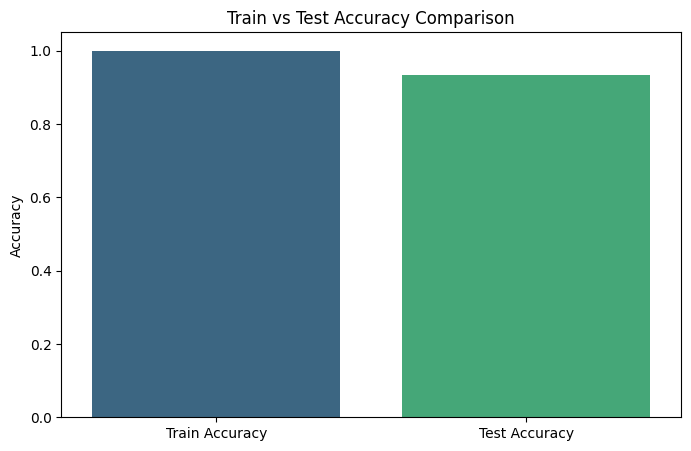


Train Accuracy: 1.0000
Test Accuracy: 0.9347


In [35]:
from sklearn.metrics import classification_report, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Training and Testing predictions (assuming you have them)
y_pred_train = xgb_model.predict(X_train)  # Example: Change to your model
y_pred_test = xgb_model.predict(X_test)  # Example: Change to your model

# Accuracy for train and test data
train_accuracy = accuracy_score(y_train, y_pred_train)
test_accuracy = accuracy_score(y_test, y_pred_test)

# Classification reports for train and test data
train_class_report = classification_report(y_train, y_pred_train, output_dict=True)
test_class_report = classification_report(y_test, y_pred_test, output_dict=True)

# Display classification reports
print("Train Classification Report:")
print(pd.DataFrame(train_class_report).transpose())
print("\nTest Classification Report:")
print(pd.DataFrame(test_class_report).transpose())

# Bar plot for accuracy comparison
accuracies = {
    'Train Accuracy': train_accuracy,
    'Test Accuracy': test_accuracy
}

# Plotting the bar graph
plt.figure(figsize=(8, 5))
sns.barplot(x=list(accuracies.keys()), y=list(accuracies.values()), palette="viridis")
plt.ylabel("Accuracy")
plt.title("Train vs Test Accuracy Comparison")
plt.show()

# Optionally, print the overall accuracy
print(f"\nTrain Accuracy: {train_accuracy:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")


C:\Users\Ritesh\AppData\Local\Temp\ipykernel_27788\2672675988.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(accuracies.keys()), y=list(accuracies.values()), palette="viridis")


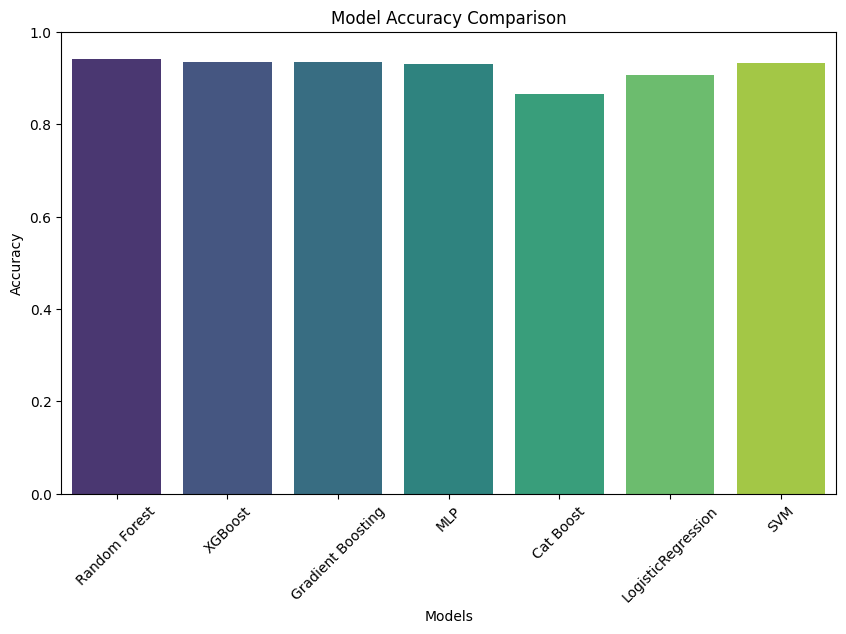

In [39]:
# Store the accuracies for each model
accuracies = {
    'Random Forest': rf_accuracy,
    'XGBoost': xgb_accuracy,
    'Gradient Boosting': gb_accuracy,
    'MLP': mlp_accuracy,
    'Cat Boost':catboost_accuracy,
    'LogisticRegression':logreg_accuracy,
    'SVM':svm_accuracy
}

# Plot accuracy scores
plt.figure(figsize=(10, 6))
sns.barplot(x=list(accuracies.keys()), y=list(accuracies.values()), palette="viridis")
plt.xlabel("Models")
plt.ylabel("Accuracy")
plt.ylim(0, 1)  # Accuracy ranges from 0 to 1
plt.title("Model Accuracy Comparison")
plt.xticks(rotation=45)
plt.show()
